# Overview
In this project, I will segment users based on Customer Lifetime Value using the RFM (Recency, Frequency, Monetary) model using method KMeans clustering. The idea is to group users according to:

1/ Recency – Indicates how recently a user was active on our product. It is calculated based on the number of days since the user’s last activity. The fewer days since their last activity, the more valuable the user is.

2/ Frequency – Reflects how often a user interacts with our product, measured by the number of orders they have placed. A higher number of orders indicates a more engaged and valuable customer.

3/ Monetary (Revenue) – Represents the revenue a user brings in, calculated based on the total value of their orders. Users with higher spending are considered more valuable.

After clustering users based on Recency, Frequency, and Monetary metrics, I will calculate a combined RFM score for each user to summarize their overall value.

# Import libraries and datasets

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go 

In [2]:
olist_customers = pd.read_csv("/Users/phuongnguyen/Documents/Code Github/mlops-ml-ecommerce-customers/sample_files/olist_dataset/olist_customers_dataset.csv")
olist_orders = pd.read_csv("/Users/phuongnguyen/Documents/Code Github/mlops-ml-ecommerce-customers/sample_files/olist_dataset/olist_orders_dataset.csv")
olist_orders_payment = pd.read_csv("/Users/phuongnguyen/Documents/Code Github/mlops-ml-ecommerce-customers/sample_files/olist_dataset/olist_order_payments_dataset.csv")

In [3]:
olist_customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
olist_orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
olist_orders_payment.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


We need to merge dataset of orders and customers and payment to distinguish between customer_unique_id (presented for one customer) could order multiple order_id (same with customer_id - presented for one order in customer_id)

In [6]:
#merge dataset orders and customers to solve unique_customer_id
orders_bycus = pd.merge(olist_orders, olist_customers, on = 'customer_id')

In [7]:
#merge dataset orders by customer and their payment for further use
orders_payment_bycus = pd.merge(orders_bycus, olist_orders_payment, on = 'order_id')

In [8]:
print(orders_payment_bycus.columns)

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


# Recency and Customer Clustering based on Recency

In [9]:
#Get the maximum date of order_purchase_timestamp to get the latest date of the order dataset
max_date = orders_payment_bycus['order_purchase_timestamp'].max()
max_date_timestamp = pd.to_datetime(max_date)
print(max_date)

2018-10-17 17:30:18


In [10]:
#Convert Order Purchase timestamp to_datetime for further calculation
orders_payment_bycus['purchase_timestamp'] = pd.to_datetime(orders_payment_bycus['order_purchase_timestamp'])

In [11]:
orders_payment_bycus['last_order'] = max_date_timestamp - orders_payment_bycus['purchase_timestamp']
orders_payment_bycus['recency'] = orders_payment_bycus['last_order'].dt.days

In [12]:
orders_payment_bycus.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,purchase_timestamp,last_order,recency
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12,2017-10-02 10:56:33,380 days 06:33:45,380
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00,2017-10-02 10:56:33,380 days 06:33:45,380
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,voucher,1,18.59,2017-10-02 10:56:33,380 days 06:33:45,380
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,boleto,1,141.46,2018-07-24 20:41:37,84 days 20:48:41,84
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,credit_card,3,179.12,2018-08-08 08:38:49,70 days 08:51:29,70


In [13]:
olist_orders_recency = orders_payment_bycus[['customer_unique_id', 'recency']]

In [14]:
print(olist_orders_recency.count())

customer_unique_id    103886
recency               103886
dtype: int64


In [15]:
#Count duplicate customer_unique_id 
#Count number of customer_unique_id
dupes = olist_orders_recency['customer_unique_id'].value_counts()

#Filter ID duplicates
duplicated_customers = dupes[dupes > 1]

#Count number of duplicated ids
num_duplicated_ids = len(duplicated_customers)

print(f"Number of customer_unique_id duplicated: {num_duplicated_ids}")

Number of customer_unique_id duplicated: 5729


In [16]:
#Filter dataframe with the same customer_unique_id, get the min recency
olist_orders_recency = olist_orders_recency.loc[olist_orders_recency.groupby('customer_unique_id')['recency'].idxmin()]

In [17]:
print(olist_orders_recency.count())

customer_unique_id    96095
recency               96095
dtype: int64


In [18]:
olist_orders_recency

,customer_unique_id,recency
55202,0000366f3b9a7992bf8c76cfdf3221e2,160
77154,0000b849f77a49e4a4ce2b2a4ca5be3f,163
27681,0000f46a3911fa3c0805444483337064,585
102896,0000f6ccb0745a6a4b88665a16c9f078,369
43505,0004aac84e0df4da2b147fca70cf8255,336
...,...,...
90881,fffcf5a5ff07b0908bd4e2dbc735a684,495
21456,fffea47cd6d3cc0a88bd621562a9d061,310
45981,ffff371b4d645b6ecea244b27531430a,617
101154,ffff5962728ec6157033ef9805bacc48,168


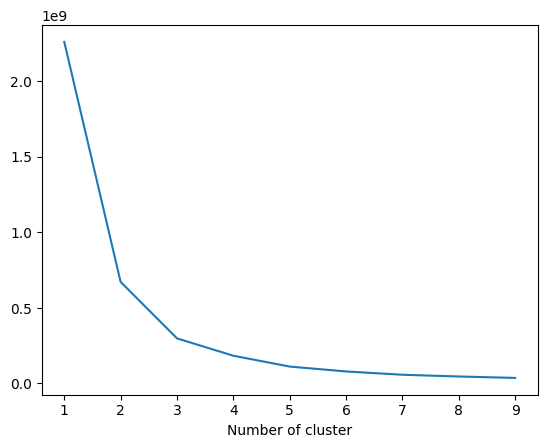

In [19]:
sse = {}
olist_recency = olist_orders_recency[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(olist_recency)
    olist_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [20]:
#Build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters =4)
olist_orders_recency['recency_cluster'] = kmeans.fit_predict(olist_orders_recency[['recency']])

In [21]:
olist_orders_recency.head(10)

,customer_unique_id,recency,recency_cluster
55202,0000366f3b9a7992bf8c76cfdf3221e2,160,1
77154,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1
27681,0000f46a3911fa3c0805444483337064,585,2
102896,0000f6ccb0745a6a4b88665a16c9f078,369,0
43505,0004aac84e0df4da2b147fca70cf8255,336,0
82008,0004bd2a26a76fe21f786e4fbd80607f,194,3
78012,00050ab1314c0e55a6ca13cf7181fecf,180,3
7131,00053a61a98854899e70ed204dd4bafe,231,3
74356,0005e1862207bf6ccc02e4228effd9a0,591,2
71892,0005ef4cd20d2893f0d9fbd94d3c0d97,219,3


In [22]:
olist_orders_recency.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,25064.0,362.701923,43.263521,298.0,325.0,356.0,399.0,447.0
1,25939.0,110.566406,36.071041,0.0,77.0,110.0,144.0,171.0
2,17323.0,533.278589,59.809455,448.0,485.0,524.0,576.0,772.0
3,27769.0,232.372754,35.122056,172.0,203.0,232.0,263.0,297.0


In [23]:
#reorder clusters so that cluster 3 is better than cluster 1 means that with cluster 1: the mean is longer than cluster 3
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [24]:
olist_orders_recency.head(5)

,customer_unique_id,recency,recency_cluster
55202,0000366f3b9a7992bf8c76cfdf3221e2,160,1
77154,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1
27681,0000f46a3911fa3c0805444483337064,585,2
102896,0000f6ccb0745a6a4b88665a16c9f078,369,0
43505,0004aac84e0df4da2b147fca70cf8255,336,0


In [25]:
olist_orders_recency_ordered = order_cluster('recency_cluster', 'recency', olist_orders_recency, False)

In [26]:
olist_orders_recency_ordered.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,17323.0,533.278589,59.809455,448.0,485.0,524.0,576.0,772.0
1,25064.0,362.701923,43.263521,298.0,325.0,356.0,399.0,447.0
2,27769.0,232.372754,35.122056,172.0,203.0,232.0,263.0,297.0
3,25939.0,110.566406,36.071041,0.0,77.0,110.0,144.0,171.0


In [27]:
olist_orders_recency_ordered.head(10)

,customer_unique_id,recency,recency_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,160,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,3
2,000e309254ab1fc5ba99dd469d36bdb4,114,3
3,000ec5bff359e1c0ad76a81a45cb598f,57,3
4,000ed48ceeb6f4bf8ad021a10a3c7b43,150,3
5,000fbf0473c10fc1ab6f8d2d286ce20c,83,3
6,0015752e079902b12cd00b9b7596276b,75,3
7,00172711b30d52eea8b313a7f2cced02,65,3
8,001928b561575b2821c92254a2327d06,53,3
9,00196c4c9a3af7dd2ad10eade69c926f,81,3


# Frequency and Customer Clustering based on Frequency

In [28]:
olist_customers_frequency = orders_payment_bycus.groupby('customer_unique_id')['order_id'].nunique().reset_index()
olist_customers_frequency.columns = ['customer_unique_id', 'frequency']


In [29]:
print(olist_customers_frequency[olist_customers_frequency['frequency'] == 17])

                     customer_unique_id  frequency
52972  8d50f5eadf50201ccdcedfb9e2ac8455         17


In [30]:
print(orders_payment_bycus[orders_payment_bycus['customer_unique_id']== '8d50f5eadf50201ccdcedfb9e2ac8455'])

                                order_id                       customer_id  \
2450    c2213109a2cc0e75d55585b7aaac6d97  897b7f72042714efaa64ac306ba0cafc   
3819    23427a6bd9f8fd1b51f1b1e5cc186ab8  a8fabc805e9a10a3c93ae5bff642b86b   
5371    e3071b7624445af6e4f3a1b23718667d  0bf8bf19944a7f8b40ba86fef778ca7c   
12204   d3582fd5ccccd9cb229a63dfb417c86f  a682769c4bc10fc6ef2101337a6c83c9   
16912   5837a2c844decae8a778657425f6d664  31dd055624c66f291578297a551a6cdf   
19956   bf92c69b7cc70f7fc2c37de43e366173  42dbc1ad9d560637c9c4c1533746f86d   
25996   6bdf325f0966e3056651285c0aed5aad  6289b75219d757a56c0cce8d9e427900   
35273   4f62d593acae92cea3c5662c76122478  dfb941d6f7b02f57a44c3b7c3fefb44b   
41302   b850a16d8faf65a74c51287ef34379ce  1bd3585471932167ab72a84955ebefea   
61447   519203404f6116d406a970763ee75799  1c62b48fb34ee043310dcb233caabd2e   
69681   a1a6eadae352582010f449d8527b55f3  3414a9c813e3ca02504b8be8b2deb27f   
71676   5d848f3d93a493c1c8955e018240e7ca  0e4fdc084a6b9329ed55d6

In [31]:
olist_customers_frequency.describe()

,frequency
count,96095.000000
mean,1.034809
std,0.214385
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,17.000000


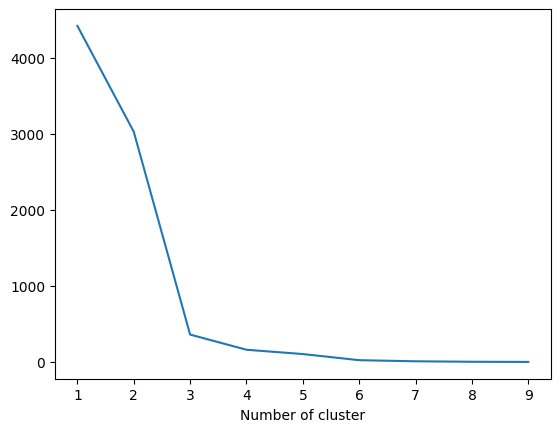

In [32]:
#clustering customer based on their revenue
from sklearn.cluster import KMeans

sse = {}
olist_revenue = olist_customers_frequency[['frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(olist_revenue)
    olist_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [33]:
#Apply clustering
kmeans = KMeans(n_clusters=4)
olist_customers_frequency['frequency_cluster'] = kmeans.fit_predict(olist_customers_frequency[['frequency']])

In [34]:
print(olist_customers_frequency)

                     customer_unique_id  frequency  frequency_cluster
0      0000366f3b9a7992bf8c76cfdf3221e2          1                  0
1      0000b849f77a49e4a4ce2b2a4ca5be3f          1                  0
2      0000f46a3911fa3c0805444483337064          1                  0
3      0000f6ccb0745a6a4b88665a16c9f078          1                  0
4      0004aac84e0df4da2b147fca70cf8255          1                  0
...                                 ...        ...                ...
96090  fffcf5a5ff07b0908bd4e2dbc735a684          1                  0
96091  fffea47cd6d3cc0a88bd621562a9d061          1                  0
96092  ffff371b4d645b6ecea244b27531430a          1                  0
96093  ffff5962728ec6157033ef9805bacc48          1                  0
96094  ffffd2657e2aad2907e67c3e9daecbeb          1                  0

[96095 rows x 3 columns]


In [35]:
olist_customers_frequency.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,93098.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2948.0,2.068860,0.253259,2.0,2.0,2.0,2.0,3.0
2,48.0,4.708333,1.129080,4.0,4.0,4.0,5.0,9.0
3,1.0,17.000000,NaN,17.0,17.0,17.0,17.0,17.0


In [36]:
#reorder clusters so that cluster 3 is better than cluster 1 means that with cluster 1: the mean (frequency) is higher than the mean (frequency) of cluster 3
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [37]:
olist_orders_frequency_ordered = order_cluster('frequency_cluster', 'frequency', olist_customers_frequency, True)

In [38]:
olist_orders_frequency_ordered.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,93098.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
1,2948.0,2.068860,0.253259,2.0,2.0,2.0,2.0,3.0
2,48.0,4.708333,1.129080,4.0,4.0,4.0,5.0,9.0
3,1.0,17.000000,NaN,17.0,17.0,17.0,17.0,17.0


# Revenue and Customer Clustering based on Revenue

In [39]:
orders_payment_bycus.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value,purchase_timestamp,last_order,recency
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,credit_card,1,18.12,2017-10-02 10:56:33,380 days 06:33:45,380
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,3,voucher,1,2.00,2017-10-02 10:56:33,380 days 06:33:45,380
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2,voucher,1,18.59,2017-10-02 10:56:33,380 days 06:33:45,380
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,boleto,1,141.46,2018-07-24 20:41:37,84 days 20:48:41,84
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,credit_card,3,179.12,2018-08-08 08:38:49,70 days 08:51:29,70


In [40]:
olist_customers_revenue = orders_payment_bycus.groupby(['customer_unique_id'], sort = True)['payment_value'].sum()

In [41]:
olist_customers_revenue = olist_customers_revenue.to_frame().reset_index()
print(type(olist_customers_revenue))

<class 'pandas.core.frame.DataFrame'>


In [42]:
#rename column after convert to dataframe
olist_customers_revenue.columns = ['customer_unique_id', 'revenue']

In [43]:
olist_customers_revenue.head(5)

,customer_unique_id,revenue
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


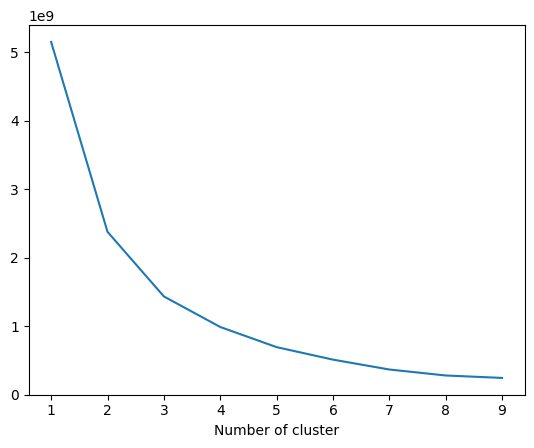

In [44]:
#clustering customer based on their revenue
from sklearn.cluster import KMeans

sse = {}
olist_revenue = olist_customers_revenue[['revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(olist_revenue)
    olist_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [45]:
olist_revenue.head()

,revenue,clusters
0,141.90,0
1,27.19,2
2,86.22,2
3,43.62,2
4,196.89,0


In [46]:
#apply clustering
kmeans = KMeans(n_clusters=4)
olist_customers_revenue['revenue_cluster'] = kmeans.fit_predict(olist_customers_revenue[['revenue']])

In [47]:
print(olist_customers_revenue)

                     customer_unique_id  revenue  revenue_cluster
0      0000366f3b9a7992bf8c76cfdf3221e2   141.90                0
1      0000b849f77a49e4a4ce2b2a4ca5be3f    27.19                0
2      0000f46a3911fa3c0805444483337064    86.22                0
3      0000f6ccb0745a6a4b88665a16c9f078    43.62                0
4      0004aac84e0df4da2b147fca70cf8255   196.89                0
...                                 ...      ...              ...
96090  fffcf5a5ff07b0908bd4e2dbc735a684  2067.42                3
96091  fffea47cd6d3cc0a88bd621562a9d061    84.58                0
96092  ffff371b4d645b6ecea244b27531430a   112.46                0
96093  ffff5962728ec6157033ef9805bacc48   133.69                0
96094  ffffd2657e2aad2907e67c3e9daecbeb    71.56                0

[96095 rows x 3 columns]


In [48]:
olist_customers_revenue.groupby('revenue_cluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
revenue_cluster,,,,,,,,
0,83500.0,107.345366,60.576358,0.00,57.98,94.400,147.3500,270.13
1,92.0,3622.704565,1652.442074,2480.58,2757.72,3046.195,3801.1425,13664.08
2,11016.0,432.219415,150.033134,270.15,316.29,377.665,512.0850,873.28
3,1487.0,1311.981271,388.084087,873.86,1005.81,1215.150,1514.7800,2467.33


In [49]:
#reorder clusters so that cluster 3 is better than cluster 1 means that with cluster 1: the mean (revenue) is higher than the mean (revenue) of cluster 3
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [50]:
olist_orders_revenue_ordered = order_cluster('revenue_cluster', 'revenue', olist_customers_revenue, True)

In [51]:
olist_orders_revenue_ordered.groupby('revenue_cluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
revenue_cluster,,,,,,,,
0,83500.0,107.345366,60.576358,0.00,57.98,94.400,147.3500,270.13
1,11016.0,432.219415,150.033134,270.15,316.29,377.665,512.0850,873.28
2,1487.0,1311.981271,388.084087,873.86,1005.81,1215.150,1514.7800,2467.33
3,92.0,3622.704565,1652.442074,2480.58,2757.72,3046.195,3801.1425,13664.08


In [52]:
olist_orders_revenue_ordered.head(10)

,customer_unique_id,revenue,revenue_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,0
2,0000f46a3911fa3c0805444483337064,86.22,0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,0
4,0004aac84e0df4da2b147fca70cf8255,196.89,0
5,0004bd2a26a76fe21f786e4fbd80607f,166.98,0
6,00050ab1314c0e55a6ca13cf7181fecf,35.38,0
7,0005e1862207bf6ccc02e4228effd9a0,150.12,0
8,0005ef4cd20d2893f0d9fbd94d3c0d97,129.76,0
9,0006fdc98a402fceb4eb0ee528f6a8d4,29.00,0


# Overall score and Customer Clustering

In [53]:
#Merge recency-frequency-monetary clustering value to see details
order_rfm = pd.merge(olist_orders_recency_ordered, olist_orders_frequency_ordered, on = 'customer_unique_id')
order_rfm = pd.merge(order_rfm, olist_orders_revenue_ordered, on = 'customer_unique_id')
order_rfm.head(5)

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,revenue,revenue_cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,160,3,1,0,141.90,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,3,1,0,27.19,0
2,000e309254ab1fc5ba99dd469d36bdb4,114,3,1,0,78.42,0
3,000ec5bff359e1c0ad76a81a45cb598f,57,3,1,0,27.75,0
4,000ed48ceeb6f4bf8ad021a10a3c7b43,150,3,1,0,20.75,0


In [54]:
order_rfm['rfm_score'] = order_rfm['recency_cluster'] + order_rfm['frequency_cluster'] + order_rfm['revenue_cluster']

In [55]:
order_rfm.groupby('rfm_score')[['recency', 'frequency', 'revenue']].mean()

,recency,frequency,revenue
rfm_score,,,
0,532.447605,1.000000,104.297418
1,378.669352,1.012514,131.985697
2,251.752443,1.022853,151.772800
3,132.799053,1.033446,167.622775
4,135.448267,1.243646,501.329669
5,119.409091,1.576623,985.540182
6,118.344828,2.425287,1889.120345
7,102.285714,4.714286,2562.105714
8,63.500000,10.500000,2791.770000


As we can see, with rfm_score = 0 is our worst customer (low active user, low number of order, low revenue). rfm_score = 8 is our beloved customer (very active user, high number of orders, high revenue)

In [66]:
#Segment user with Low-value, Mid-value, High-value. I segment based mainly on Revenue first
order_rfm['Segment'] = 'Low-Value'
order_rfm.loc[order_rfm['rfm_score']>= 3,'Segment'] = 'Mid-Value' 
order_rfm.loc[order_rfm['rfm_score']>= 5,'Segment'] = 'High-Value' 

In [67]:
order_rfm.head(5)

,customer_unique_id,recency,recency_cluster,frequency,frequency_cluster,revenue,revenue_cluster,rfm_score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,160,3,1,0,141.90,0,3,Mid-Value
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,3,1,0,27.19,0,3,Mid-Value
2,000e309254ab1fc5ba99dd469d36bdb4,114,3,1,0,78.42,0,3,Mid-Value
3,000ec5bff359e1c0ad76a81a45cb598f,57,3,1,0,27.75,0,3,Mid-Value
4,000ed48ceeb6f4bf8ad021a10a3c7b43,150,3,1,0,20.75,0,3,Mid-Value


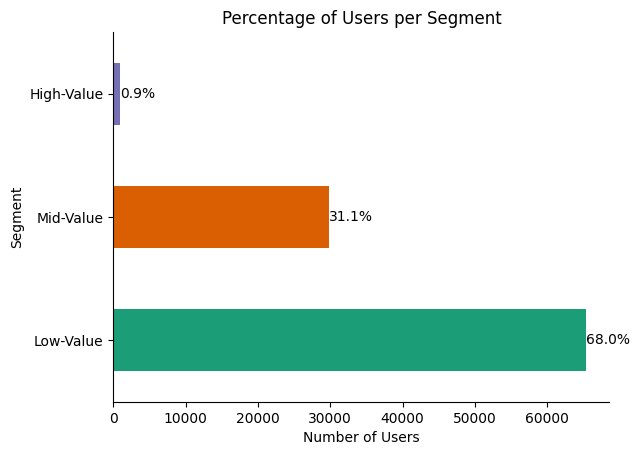

In [68]:
#Visualize the bar chart based on user segmentation
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the count and percentage for each segment
segment_counts = order_rfm['Segment'].value_counts()
segment_percentages = segment_counts / len(order_rfm) * 100

# Create the bar plot
ax = segment_counts.plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))

# Add percentages as annotations
for index, value in enumerate(segment_counts):
    percentage = segment_percentages.iloc[index]
    ax.text(value, index, f'{percentage:.1f}%', va='center')

plt.gca().spines[['top', 'right',]].set_visible(False)
plt.xlabel("Number of Users")
plt.ylabel("Segment")
plt.title("Percentage of Users per Segment")
plt.show()

In [69]:
#export to csv file for customer lifetime value prediction 
order_rfm.to_csv("/Users/phuongnguyen/Documents/Code Github/mlops-ml-ecommerce-customers/sample_files/customer_segmentation_ltv.csv")

# References:
- My blog 'Customer Segmentation based on Customer Lifetime Value' https://open.substack.com/pub/quynhanhphuong/p/customer-segmentation-based-on-lifetime?r=1xb8sg&utm_campaign=post&utm_medium=web&showWelcomeOnShare=false
- Notebook reference: https://www.kaggle.com/code/shailaja4247/customer-lifetime-value-prediction